In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


data_path = '/content/drive/MyDrive/images/'
csv_file = '/content/drive/MyDrive/val.csv'

Mounted at /content/drive


In [ ]:
data_df = pd.read_csv(csv_file)
data_df['id_code'] = data_df['id_code'].str.strip()

images_path = data_path

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32


def load_image(image_id, directory):
    file_path = os.path.join(directory, image_id + ".png")
    img = cv2.imread(file_path)
    if img is None:
        print(f"Warning: Image not found at {file_path}")
        return np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))  # Return a black image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img


X = []
for image_id in data_df['id_code']:
    image = load_image(image_id, images_path)
    X.append(image)

X = np.array(X)
y = data_df['diagnosis'].values

X = X / 255.0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator()

In [ ]:
def build_densenet():
    base_model = DenseNet121(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')


    for layer in base_model.layers[-10:]: #son 10 katmani çöz
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(5, activation='softmax')(x)  # 5 classes

    return Model(inputs=base_model.input, outputs=output)

model = build_densenet()


In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


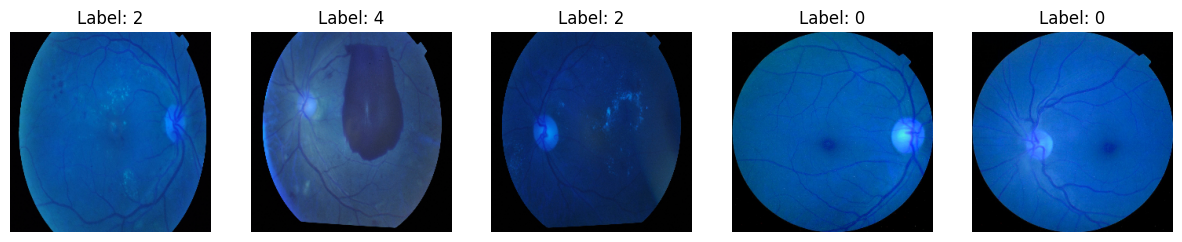

In [ ]:

def visualize_images(X, y, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        index = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[index])
        plt.title(f'Label: {y[index]}')
        plt.axis('off')
    plt.show()


visualize_images(X_train, y_train, num_images=5)

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6328 - loss: 1.0064

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6335 - loss: 1.0045 - val_accuracy: 0.6150 - val_loss: 1.1443 - learning_rate: 1.0000e-04
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.7676 - loss: 0.6195 - val_accuracy: 0.7810 - val_loss: 0.6224 - learning_rate: 1.0000e-04
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - accuracy: 0.7958 - loss: 0.5386 - val_accuracy: 0.7774 - val_loss: 0.6039 - learning_rate: 1.0000e-04
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8083 - loss: 0.4959 - val_accuracy: 0.8066 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.8409 - loss: 0.4309 - val_accuracy: 0.7427 - val_loss: 0.6656 - learning_rate: 1.0000e-04
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8392 - loss: 0.4084 - val_accuracy: 0.8376 - val_loss: 0.4750 - learning_rate: 1.0000e-04
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.8497

In [ ]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')


Validation Accuracy: 85.95%


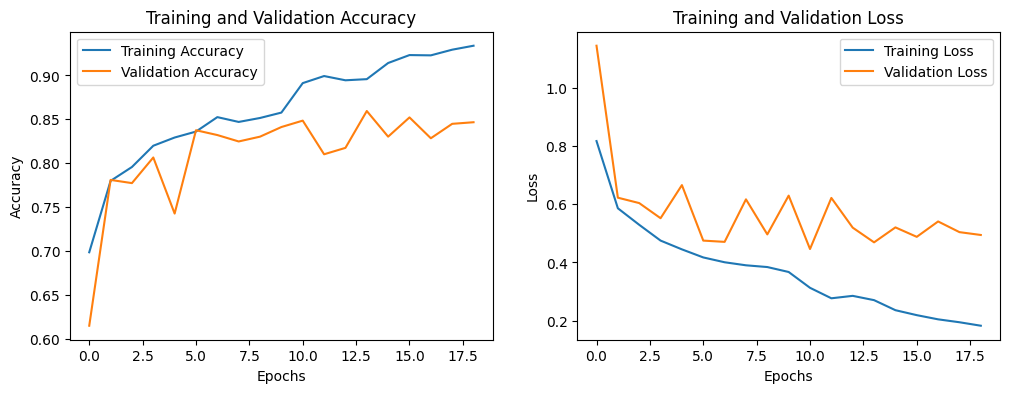

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the Model
model.save('/content/drive/MyDrive/retinopathy_densenet_model.h5')
